## Choice Set Generation Large

In [2]:
#!pip install choicedesign
from choicedesign.design import EffDesign
from biogeme.expressions import Beta, Variable
from biogeme.expressions import bioDraws, MonteCarlo
import biogeme.database as db
import biogeme.models as models
import pandas as pd

In [15]:
#in algorithmy.py change iterperf.copy()  to interperf , and similar 
#change in design.py the:  for k in range(len(self.fixed)):
 #           if self.fixed[k] is not None: 
  #              init_design[self.fixed[k],k] = 0

In [3]:
alts = ['alt1', 'alt2'] #number of doors per choice set
ncs = 24 # number of choice sets

In [4]:
# Define trip attributes
# T2DR = {'name': 'T2DR', 'levels': [1,2,4], 'avail': ['alt1', 'alt2']} #Time to departure of most recent trip
# T2DS = {'name': 'T2DS', 'levels': [5,10], 'avail': ['alt1', 'alt2']} #Time to departure of subsequent trip
# TRyeschange = {'name': 'TRyeschange', 'levels': [0,1], 'avail': ['alt1', 'alt2']} # Dummy variable
# TRyesnochange = {'name': 'TRyesnochange', 'levels': [0,1], 'avail': ['alt1', 'alt2']} # Dummy variable
# TT = {'name': 'TT', 'levels': [10,30,60], 'avail': ['alt1', 'alt2']} #Total travel time

# #Define door attributes
D2E = {'name': 'D2E', 'levels': [0,40,80], 'avail': ['alt1', 'alt2']} #Distance from door to platform exit at destination in meters
D2D = {'name': 'D2D', 'levels': [70, 30, 10, 0], 'avail': ['alt1', 'alt2']} #Distance from current position of participant to the door in meters
O = {'name': 'O', 'levels': [0, 1], 'avail': ['alt1', 'alt2']} # Obstacle yes no
CD = {'name': 'CD', 'levels': [0,5,10], 'avail': ['alt1', 'alt2']} #Crowding at the door in persons
CP = {'name': 'CP', 'levels': [1,4], 'avail': ['alt1', 'alt2']} #Crowding on the platform in pax per m2 between participant and door
#As CTD is a categorical variable with 4 levels, we need to create 3 dummy variables
# CTDred = {'name': 'CTDred', 'levels': [0,1], 'avail': ['alt1', 'alt2']} # Dummy variable
# CTDyellow = {'name': 'CTDyellow', 'levels': [0,1], 'avail': ['alt1', 'alt2']} #
# CTDgreen = {'name': 'CTDgreen', 'levels': [0,1], 'avail': ['alt1', 'alt2']} # Dummy variable
# #As CTL is a categorical variable with 4 levels, we need to create 3 dummy variables
# CTLred = {'name': 'CTLred', 'levels': [0,1], 'avail': ['alt1', 'alt2']} # Dummy variable
# CTLyellow = {'name': 'CTLyellow', 'levels': [0,1], 'avail': ['alt1', 'alt2']} # Dummy variable
# CTLgreen = {'name': 'CTLgreen', 'levels': [0,1], 'avail': ['alt1', 'alt2']} # Dummy variable
#Crowding level as one attribute and color as the other 
CrowdingRed = {'name': 'CrowdingRed', 'levels': [0,1], 'avail': ['alt1', 'alt2']} # Dummy variable with yellow = reference
CrowdingGreen = {'name': 'CrowdingGreen', 'levels': [0,1], 'avail': ['alt1', 'alt2']} # Dummy variable
#Crowding info 
CIL = {'name': 'CIL', 'levels': [0,1], 'avail': ['alt1', 'alt2']} #Crowding info led yes no
CID = {'name': 'CID', 'levels': [0,1], 'avail': ['alt1', 'alt2']} #Crowding info display yes no



D = {'name': 'D', 'levels': [0,10,25,50], 'avail': ['alt1', 'alt2']} #Discount offered on regular price in percent
RC = {'name': 'RC', 'levels': [0,1], 'avail': ['alt1', 'alt2']} #Recent trip or subsequent. Recent =1, subsequent =0



Generating choice design

In [5]:
design = EffDesign(
    alts=alts,
    ncs=ncs,
     atts_list=[
    D2E, D2D, O, CD, CP, CrowdingRed, CrowdingGreen, CIL, CID,
    D, RC],
    )

In [6]:
cond = [
#trip conditions
#     'alt1_T2DR == alt2_T2DR', #time to departure must be same 
#    'alt1_T2DS == alt2_T2DS',#time to departure subsequent must be the same 
#    'alt1_TRyeschange == alt2_TRyeschange', #previous transfer with change must be the same
#    'alt1_TRyesnochange == alt2_TRyesnochange', #previous transfer
#    'alt1_TT == alt2_TT', #total travel time must be the same 

# #Door conditions 
    'if (alt1_O == 1) & (alt1_D2D <= alt2_D2D) then (alt2_O == 1)', #if obstacle present at door with shorter distance, obstacle must also be present at other door
    'if (alt2_O == 1) & (alt2_D2D <= alt1_D2D) then (alt1_O == 1)', #if obstacle present at door with shorter distance, obstacle must also be present at other door
    'if (alt1_D2D <= alt2_D2D) & (alt1_CD > 0) then (alt2_CP == 4)', #if door 1 is closer & has crowding, door 2 must have high crowding on platform
    'if (alt2_D2D <= alt1_D2D) & (alt2_CD > 0) then (alt1_CP == 4)', #if door 2 is closer & has crowding, door 1 must have high crowding on platform 
    'if (alt1_D2D == 0) then (alt1_CP== 1)', #if distance to door is zero, crowding on platform must be low 
    'if (alt1_D2D < alt2_D2D) then (alt2_CP >= alt1_CP)', #if door 1 is closer, door 2 must have equal or higher crowding on platform
    'if (alt2_D2D < alt1_D2D) then (alt1_CP >= alt2_CP)', #if door 2 is closer, door 1 must have equal or higher crowding on platform
    'if (alt1_D2D == alt2_D2D) then (alt2_CP == alt1_CP)', #if door 1 is closer, door 2 must have equal or higher crowding on platform
    'if (alt2_D2D == alt1_D2D) then (alt1_CP == alt2_CP)', #if door 2 is closer, door 1 must have equal or higher crowding on platform
    

    #Remove dominant 
    'if (alt1_D2E <= alt2_D2E) & (alt1_D2D <= alt2_D2D) & (alt1_O <= alt2_O) & (alt1_CD <= alt2_CD) & (alt1_CP <= alt2_CP) & (alt1_D >= alt2_D) & (((alt1_CrowdingGreen == 1) & ((alt2_CrowdingRed == 1) | ((alt2_CrowdingRed == 0) & (alt2_CrowdingGreen == 0)) | alt2_CrowdingGreen == 1)) | (((alt1_CrowdingRed== 0) & (alt1_CrowdingGreen == 0)) & ((alt2_CrowdingRed == 1) | ((alt2_CrowdingRed==0)& (alt2_CrowdingGreen ==0)))) | ((alt1_CrowdingRed == 1) & (alt2_CrowdingRed == 1))) & (alt1_RC >= alt2_RC) then (1==0)', 
    'if (alt2_D2E <= alt1_D2E) & (alt2_D2D <= alt1_D2D) & (alt2_O <= alt1_O) & (alt2_CD <= alt1_CD) & (alt2_CP <= alt1_CP) & (alt2_D >= alt1_D) & (((alt2_CrowdingGreen == 1) & ((alt1_CrowdingRed == 1) | ((alt1_CrowdingRed == 0) & (alt1_CrowdingGreen == 0)) | alt1_CrowdingGreen == 1)) | (((alt2_CrowdingRed== 0) & (alt2_CrowdingGreen == 0)) & ((alt1_CrowdingRed == 1) | ((alt1_CrowdingRed==0)& (alt1_CrowdingGreen ==0)))) | ((alt2_CrowdingRed == 1) & (alt1_CrowdingRed == 1))) & (alt2_RC >= alt1_RC)  then (1==0)',

    #Dummy variable 
    'alt1_CrowdingRed + alt1_CrowdingGreen <= 1',
    'alt2_CrowdingRed + alt2_CrowdingGreen <= 1',
    'if (alt1_CID == 0) & (alt1_CIL == 0) then ((alt1_CrowdingRed == 0) & (alt1_CrowdingGreen == 0))',
    'if (alt2_CID == 0) & (alt2_CIL == 0)  then ((alt2_CrowdingRed == 0) & (alt2_CrowdingGreen == 0))'


]

Generating initial choice design

In [7]:
init_design = design.gen_initdesign(cond = cond, seed=1)

print(init_design)


    alt1_D2E  alt1_D2D  alt1_O  alt1_CD  alt1_CP  alt1_CrowdingRed  \
0          0        10       1       10        4                 0   
1          0        70       0        5        4                 0   
2         40         0       0       10        1                 0   
3          0        70       0       10        4                 0   
4         40        70       1       10        4                 0   
5         40        30       1       10        4                 1   
6         80        70       1        5        4                 0   
7         40         0       1        0        1                 1   
8         40        70       0       10        4                 0   
9          0        10       0        5        4                 0   
10        40        70       1       10        4                 0   
11        80        70       0        0        4                 0   
12        80         0       0        0        1                 1   
13        40        

In [8]:
#Variables for alternative 1
alt1_D2E=Variable('alt1_D2E')
alt1_D2D=Variable('alt1_D2D')
alt1_O=Variable('alt1_O')
alt1_CD=Variable('alt1_CD')
alt1_CP=Variable('alt1_CP')
alt1_CrowdingRed=Variable('alt1_CrowdingRed')
alt1_CrowdingGreen=Variable('alt1_CrowdingGreen')
alt1_CIL = Variable('alt1_CIL')
alt1_CID = Variable('alt1_CID')
# alt1_CTDred=Variable('alt1_CTDred')
# alt1_CTDyellow=Variable('alt1_CTDyellow')
# alt1_CTDgreen=Variable('alt1_CTDgreen')
# alt1_CTLred=Variable('alt1_CTLred')
# alt1_CTLyellow=Variable('alt1_CTLyellow')
# alt1_CTLgreen=Variable('alt1_CTLgreen')
alt1_D=Variable('alt1_D')
alt1_RC=Variable('alt1_RC')

#Variables for alternative 2
alt2_D2E=Variable('alt2_D2E')
alt2_D2D=Variable('alt2_D2D')
alt2_O=Variable('alt2_O')
alt2_CD=Variable('alt2_CD')
alt2_CP=Variable('alt2_CP')
alt2_CrowdingRed=Variable('alt2_CrowdingRed')
alt2_CrowdingGreen=Variable('alt2_CrowdingGreen')
alt2_CIL= Variable('alt2_CIL')
alt2_CID= Variable('alt2_CID')

# alt2_CTDred=Variable('alt2_CTDred')
# alt2_CTDyellow=Variable('alt2_CTDyellow')
# alt2_CTDgreen=Variable('alt2_CTDgreen')
# alt2_CTLred=Variable('alt2_CTLred')
# alt2_CTLyellow=Variable('alt2_CTLyellow')
# alt2_CTLgreen=Variable('alt2_CTLgreen')
alt2_D=Variable('alt2_D')
alt2_RC=Variable('alt2_RC')

In [9]:

beta_D2E = Beta('beta_D2E',-0.002,None,None,0)
beta_D2D = Beta('beta_D2D',-0.003,None,None,0)
beta_O = Beta('beta_O',-0.1,None,None,0)
beta_CD = Beta('beta_CD',-0.02,None,None,0)
beta_CP = Beta('beta_CP',-0.05,None,None,0)
beta_CrowdingGreen = Beta('beta_CrowdingGreen',0.1,None,None,0)
beta_CrowdingRed = Beta('beta_CrowdingRed',-0.2,None,None,0)
beta_CIL = Beta('beta_CIL',0.1,None,None,0)
beta_CID = Beta('beta_CID',0.1,None,None,0)

# beta_CTDred = Beta('beta_CTDred',-1,None,None,0)
# beta_CTDyellow = Beta('beta_CTDyellow',0,None,None,0)
# beta_CTDgreen = Beta('beta_CTDgreen',1,None,None,0)
# beta_CTLred = Beta('beta_CTLred',-1,None,None,0)
# beta_CTLyellow = Beta('beta_CTLyellow',0,None,None,0)
# beta_CTLgreen = Beta('beta_CTLgreen',1,None,None,0)
beta_D = Beta('beta_D',0.004,None,None,0)
beta_asc_optout = Beta('beta_asc_optout',-0.33,None,None,0)
beta_RC = Beta('beta_RC',0.1,None,None,0)

In [10]:
sd_D2E = Beta('sd_D2E',1e-5,None,None,0)
sd_D2D = Beta('sd_D2D',1e-5,None,None,0)
sd_O = Beta('sd_O',1e-5,None,None,0)
sd_CD = Beta('sd_CD',1e-5,None,None,0)
sd_CP = Beta('sd_CP',1e-5,None,None,0)
sd_CrowdingRed = Beta('sd_CrowdingRed',1e-5,None,None,0)
sd_CrowdingGreen = Beta('sd_CrowdingGreen',1e-5,None,None,0)
sd_CIL = Beta('sd_CIL',1e-5,None,None,0)
sd_CID = Beta('sd_CID',1e-5,None,None,0)
# sd_CTDred = Beta('sd_CTDred',1e-5,None,None,0)
# sd_CTDyellow = Beta('sd_CTDyellow',1e-5,None,None,0)
# sd_CTDgreen = Beta('sd_CTDgreen',1e-5,None,None,0)
# sd_CTLred = Beta('sd_CTLred',1e-5,None,None,0)
# sd_CTLyellow = Beta('sd_CTLyellow',1e-5,None,None,0)
# sd_CTLgreen = Beta('sd_CTLgreen',1e-5,None,None,0)
sd_D = Beta('sd_D',1e-5,None,None,0)
sd_asc_optout = Beta('sd_asc_optout',1e-5,None,None,0)
sd_RC = Beta('sd_RC',1e-5,None,None,0)

In [11]:
#Random parameters

beta_D2E_rnd=beta_D2E + sd_D2E * bioDraws('beta_D2E_rnd', 'NORMAL_MLHS')
beta_D2D_rnd=beta_D2D + sd_D2D * bioDraws('beta_D2D_rnd', 'NORMAL_MLHS')
beta_O_rnd=beta_O + sd_O * bioDraws('beta_O_rnd', 'NORMAL_MLHS')
beta_CD_rnd=beta_CD + sd_CD * bioDraws('beta_CD_rnd', 'NORMAL_MLHS')
beta_CP_rnd=beta_CP + sd_CP * bioDraws('beta_CP_rnd', 'NORMAL_MLHS')
beta_CrowdingRed_rnd=beta_CrowdingRed + sd_CrowdingRed * bioDraws('beta_CrowdingRed_rnd', 'NORMAL_MLHS')
beta_CrowdingGreen_rnd=beta_CrowdingGreen + sd_CrowdingGreen * bioDraws('beta_CrowdingGreen_rnd', 'NORMAL_MLHS')
beta_CIL_rnd=beta_CIL + sd_CIL * bioDraws('beta_CIL_rnd', 'NORMAL_MLHS')
beta_CID_rnd=beta_CID + sd_CID * bioDraws('beta_CID_rnd', 'NORMAL_MLHS')
#
# beta_CTDred_rnd=beta_CTDred + sd_CTDred * bioDraws('beta_CTDred_rnd', 'NORMAL_MLHS')
# beta_CTDyellow_rnd=beta_CTDyellow + sd_CTDyellow * bioDraws('beta_CTDyellow_rnd', 'NORMAL_MLHS')
# beta_CTDgreen_rnd=beta_CTDgreen + sd_CTDgreen * bioDraws('beta_CTDgreen_rnd', 'NORMAL_MLHS')
# beta_CTLred_rnd=beta_CTLred + sd_CTLred * bioDraws('beta_CTLred_rnd', 'NORMAL_MLHS')
# beta_CTLyellow_rnd=beta_CTLyellow + sd_CTLyellow * bioDraws('beta_CTLyellow_rnd', 'NORMAL_MLHS')
# beta_CTLgreen_rnd=beta_CTLgreen + sd_CTLgreen * bioDraws('beta_CTLgreen_rnd', 'NORMAL_MLHS')
beta_D_rnd=beta_D + sd_D * bioDraws('beta_D_rnd', 'NORMAL_MLHS')    
beta_asc_optout_rnd = beta_asc_optout + sd_asc_optout * bioDraws('beta_asc_optout_rnd', 'NORMAL_MLHS')
beta_RC_rnd=beta_RC + sd_RC * bioDraws('beta_RC_rnd', 'NORMAL_MLHS')

In [12]:
V1 = (
      beta_D2E_rnd * alt1_D2E +
      beta_D2D_rnd * alt1_D2D +
      beta_O_rnd * alt1_O +
      beta_CD_rnd * alt1_CD +
      beta_CP_rnd * alt1_CP +
      beta_CrowdingRed_rnd * alt1_CrowdingRed +
      beta_CrowdingGreen_rnd * alt1_CrowdingGreen +
      beta_CIL_rnd * alt1_CIL +
      beta_CID_rnd * alt1_CID +
      # beta_CTDred_rnd * alt1_CTDred +
      # beta_CTDyellow_rnd * alt1_CTDyellow +
      # beta_CTDgreen_rnd * alt1_CTDgreen +
      # beta_CTLred_rnd * alt1_CTLred +
      # beta_CTLyellow_rnd * alt1_CTLyellow +
      # beta_CTLgreen_rnd * alt1_CTLgreen +
      beta_D_rnd * alt1_D
      + beta_RC_rnd * alt1_RC
      )

V2 = (
      beta_D2E_rnd * alt2_D2E +
      beta_D2D_rnd * alt2_D2D +
      beta_O_rnd * alt2_O +
      beta_CD_rnd * alt2_CD +
      beta_CP_rnd * alt2_CP +
      beta_CrowdingRed_rnd * alt2_CrowdingRed +
      beta_CrowdingGreen_rnd * alt2_CrowdingGreen +
      beta_CIL_rnd * alt2_CIL +
      beta_CID_rnd * alt2_CID +
      # beta_CTDred_rnd * alt2_CTDred +
      # beta_CTDyellow_rnd * alt2_CTDyellow +
      # beta_CTDgreen_rnd * alt2_CTDgreen +
      # beta_CTLred_rnd * alt2_CTLred +
      # beta_CTLyellow_rnd * alt2_CTLyellow +
      # beta_CTLgreen_rnd * alt2_CTLgreen +
      beta_D_rnd * alt2_D
      + beta_RC_rnd * alt2_RC
      )

V3 = beta_asc_optout_rnd

V = {1: V1, 2: V2, 3: V3}

In [65]:
import os
import pandas as pd

# >>> Pfade anpassen (Speicherorte)
BASIS_PFAD = (
    "/Users/lauraknappik/sciebo - Knappik, Laura (7ZX85D@rwth-aachen.de)@rwth-aachen.sciebo.de/"
    "Dokumente/Projekte/Optimal_board_and_alight/Choice_Experiment/DCE_Python/Large/"
)
CSV_ZUSAMMENFASSUNG = os.path.join(BASIS_PFAD, "d_error_vs_ncs.csv")
#ORDNER_OPT_DESIGNS = os.path.join(BASIS_PFAD, "optimal_designs_by_ncs")

#os.makedirs(ORDNER_OPT_DESIGNS, exist_ok=True)

# >>> Feste Einstellungen (ggf. anpassen)
SEED_INITDESIGN = 1
SEED_OPT = 1278
DRAWS = 2000
TIME_LIM_MIN = 5  # wie in Ihrem Beispiel
MODEL = 'mnl_bayesian'

# >>> Ihre bereits definierten Objekte/Variablen:
# alts, cond, V,
# und die Attribut-Objekte D2E, D2D, O, CD, CP, CrowdingRed, CrowdingGreen, CIL, CID, D, RC
# werden hier als bekannt vorausgesetzt.

ergebnisse = []

for ncs in range(10, 31):  # 10 bis einschließlich 30
    print(f"\n=== Starte Optimierung für ncs = {ncs} ===")

    # 1) Neues Designobjekt mit gewünschter ncs erzeugen
    design = EffDesign(
        alts=alts,
        ncs=ncs,
        atts_list=[D2E, D2D, O, CD, CP, CrowdingRed, CrowdingGreen, CIL, CID, D, RC],
    )

    # 2) Für *dieses* Design ein frisches init_design erzeugen
    init_design = design.gen_initdesign(cond=cond, seed=SEED_INITDESIGN)

    # 3) Optimieren
    optimal_design, init_perf, final_perf, final_iter, ubalance_ratio = design.optimise(
        init_design=init_design,
        V=V,
        model=MODEL,
        draws=DRAWS,
        time_lim=TIME_LIM_MIN,
        verbose=True,
        seed=SEED_OPT
    )

    # 4) D-Error erfassen
    # Annahme: final_perf ist der D-Error der Zielfunktion.
    # Falls Ihre API stattdessen z.B. design.eval(...) mit 'D-error' liefert,
    # ersetzen Sie die folgende Zeile entsprechend.
    d_error = float(final_perf)

    ergebnisse.append({
        "ncs": ncs,
        "d_error": d_error,
        "final_iter": int(final_iter),
        "ubalance_ratio": float(ubalance_ratio)
    })



# 6) Zusammenfassung als CSV speichern
df = pd.DataFrame(ergebnisse).sort_values("ncs").reset_index(drop=True)
df.to_csv(CSV_ZUSAMMENFASSUNG, index=False)

print("\n=== Zusammenfassung D-Error vs. ncs ===")
print(df)
print(f"\nGesamtübersicht gespeichert unter: {CSV_ZUSAMMENFASSUNG}")



=== Starte Optimierung für ncs = 10 ===
Evaluating initial design
Optimization complete 0:04:57 / D-error: 0.110953
Elapsed time: 0:05:00
D-error of initial design:  inf
D-error of last stored design:  0.110953
Utility Balance ratio:  95.52 %
Algorithm iterations:  1173


=== Starte Optimierung für ncs = 11 ===
Evaluating initial design
Optimization complete 0:04:41 / D-error: 0.077255
Elapsed time: 0:05:00
D-error of initial design:  0.125918
D-error of last stored design:  0.077255
Utility Balance ratio:  92.55 %
Algorithm iterations:  895


=== Starte Optimierung für ncs = 12 ===
Evaluating initial design
Optimization complete 0:04:57 / D-error: 0.088409
Elapsed time: 0:05:00
D-error of initial design:  0.132003
D-error of last stored design:  0.088409
Utility Balance ratio:  96.03 %
Algorithm iterations:  948


=== Starte Optimierung für ncs = 13 ===
Evaluating initial design
Optimization complete 0:04:59 / D-error: 0.084731
Elapsed time: 0:05:00
D-error of initial design:  0.1319

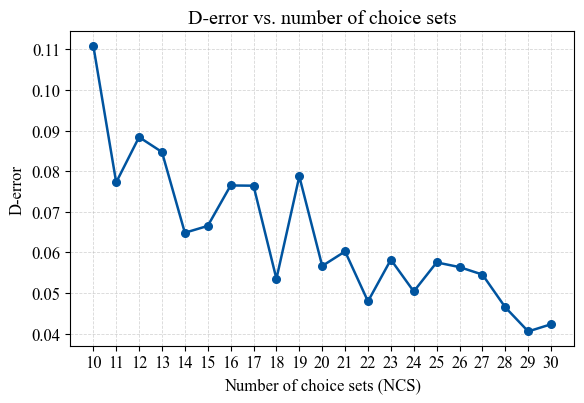

Figure saved to: /Users/lauraknappik/sciebo - Knappik, Laura (7ZX85D@rwth-aachen.de)@rwth-aachen.sciebo.de/Dokumente/Projekte/Optimal_board_and_alight/Choice_Experiment/DCE_Python/Large/d_error_vs_ncs.png


In [66]:
import os
import matplotlib.pyplot as plt

# ---- Einstellungen ----
RWTH_BLUE_100 = "#00549F"   # RWTH blue 100%
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12

# Optional: falls BASIS_PFAD aus Ihrem Code bereits existiert
save_path = os.path.join(BASIS_PFAD, "d_error_vs_ncs.png")

# ---- Plot ----
fig, ax = plt.subplots(figsize=(6, 4.2))  # moderates Seitenverhältnis

ax.plot(
    df["ncs"], df["d_error"],
    marker="o", linewidth=1.8, markersize=5.5,
    color=RWTH_BLUE_100
)

ax.set_xlabel("Number of choice sets (NCS)")
ax.set_ylabel("D-error")
ax.set_title("D-error vs. number of choice sets")
ax.grid(True, which="both", linestyle="--", linewidth=0.6, alpha=0.5)

# X-Achse als ganze Zahlen ticks (falls nicht automatisch)
ax.set_xticks(sorted(df["ncs"].unique()))

plt.tight_layout()
plt.savefig(save_path, dpi=300)
plt.show()

print(f"Figure saved to: {save_path}")


In [13]:

optimal_design, init_perf, final_perf, final_iter, ubalance_ratio = design.optimise(init_design=init_design,V=V,model='mnl_bayesian',draws=2000,time_lim = 30, verbose = True, seed=1278)

print(optimal_design)

import_df = pd.DataFrame(optimal_design)

# Export to CSV
csv_path = "/Users/lauraknappik/sciebo - Knappik, Laura (7ZX85D@rwth-aachen.de)@rwth-aachen.sciebo.de/Dokumente/Projekte/Optimal_board_and_alight/Choice_Experiment/DCE_Python/Large/choice_sets_large.csv"
import_df.to_csv(csv_path, index=False)


Evaluating initial design
Optimization complete 0:29:50 / D-error: 0.035606
Elapsed time: 0:30:01
D-error of initial design:  inf
D-error of last stored design:  0.035606
Utility Balance ratio:  93.12 %
Algorithm iterations:  3063

    CS  alt1_D2E  alt1_D2D  alt1_O  alt1_CD  alt1_CP  alt1_CrowdingRed  \
0    1        80        10       0        0        4                 0   
1    2         0        70       1       10        4                 1   
2    3        40        10       0       10        4                 0   
3    4         0        70       1       10        4                 1   
4    5        40        70       1        0        4                 0   
5    6        80        70       1       10        4                 1   
6    7         0        10       1        5        4                 0   
7    8        40         0       0        0        1                 0   
8    9        80        30       1       10        4                 0   
9   10        40        10  

In [67]:
import pandas as pd

ergebnisse = []

# time_lim in MINUTEN: 1, 2, 3, ..., 10
for m in range(5, 30):
    print(f"\n=== time_lim = {m} Minute(n) ===")
    
    optimal_design, init_perf, final_perf, final_iter, ubalance_ratio = design.optimise(init_design=init_design,V=V,model='mnl_bayesian',draws=2000,time_lim = m, verbose = True, seed=1278)
    
    ergebnisse.append({
        "time_min": m,
        "final_perf": final_perf
    })

# Übersicht als CSV speichern
df = pd.DataFrame(ergebnisse)
df.to_csv(
    "/Users/lauraknappik/sciebo - Knappik, Laura (7ZX85D@rwth-aachen.de)@rwth-aachen.sciebo.de/"
    "Dokumente/Projekte/Optimal_board_and_alight/Choice_Experiment/DCE_Python/Large/"
    "convergence_simple.csv",
    index=False
)

print(df)



=== time_lim = 5 Minute(n) ===
Evaluating initial design
Optimization complete 0:04:47 / D-error: 0.041234
Elapsed time: 0:05:01
D-error of initial design:  0.071959
D-error of last stored design:  0.041234
Utility Balance ratio:  95.37 %
Algorithm iterations:  451


=== time_lim = 6 Minute(n) ===
Evaluating initial design
Optimization complete 0:05:51 / D-error: 0.041231
Elapsed time: 0:06:00
D-error of initial design:  0.071959
D-error of last stored design:  0.041231
Utility Balance ratio:  95.17 %
Algorithm iterations:  469


=== time_lim = 7 Minute(n) ===
Evaluating initial design
Optimization complete 0:06:54 / D-error: 0.041055
Elapsed time: 0:07:01
D-error of initial design:  0.071959
D-error of last stored design:  0.041055
Utility Balance ratio:  94.98 %
Algorithm iterations:  526


=== time_lim = 8 Minute(n) ===
Evaluating initial design
Optimization complete 0:07:39 / D-error: 0.040751
Elapsed time: 0:08:01
D-error of initial design:  0.071959
D-error of last stored design

KeyboardInterrupt: 

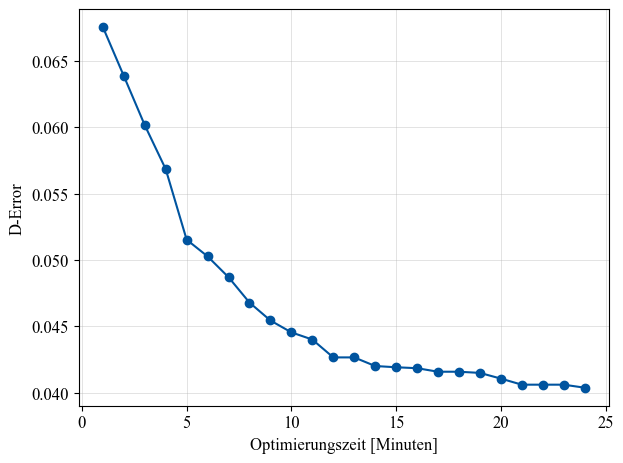

In [28]:
#!pip install matplotlib
import pandas as pd
import matplotlib.pyplot as plt

# Pfad zur erzeugten CSV-Datei
csv_path = (
    "/Users/lauraknappik/sciebo - Knappik, Laura (7ZX85D@rwth-aachen.de)@rwth-aachen.sciebo.de/"
    "Dokumente/Projekte/Optimal_board_and_alight/Choice_Experiment/DCE_Python/Large/"
    "convergence_simple.csv"
)

# CSV einlesen
df = pd.read_csv(csv_path)

# Optional: Spaltennamen prüfen (falls abweichend)
# print(df.head())

# Matplotlib global auf Times New Roman und Schriftgröße 12 setzen
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

# RWTH-Blau-100 (falls Ihre CD Vorgabe abweicht, bitte den exakten Hex-Code einsetzen)
rwth_blue_100 = "#00549F"

plt.figure()
plt.plot(
    df["time_min"],
    df["final_perf"],    # angenommen: D-Error
    marker="o",
    linestyle="-",
    color=rwth_blue_100
)

plt.xlabel("Optimierungszeit [Minuten]")
plt.ylabel("D-Error")
plt.grid(True, linewidth=0.5, alpha=0.5)

plt.tight_layout()
plt.show()


In [29]:
import numpy as np

design_df = optimal_design  

def utilities(row):
    # Alt 1
    V1 = (
        -0.02 * row['alt1_D2E'] +
        -0.03 * row['alt1_D2D'] +
        -1.00 * row['alt1_O'] +
        -0.20 * row['alt1_CD'] +
        -0.50 * row['alt1_CP'] +
        -1.00 * row['alt1_CrowdingGreen'] + 
        -2.00 * row['alt1_CrowdingRed'] +
         1.00 * row['alt1_CID'] +
         1.00 * row['alt1_CIL'] +
         0.05 * row['alt1_D']
    )

    # Alt 2
    V2 = (
        -0.02 * row['alt2_D2E'] +
        -0.03 * row['alt2_D2D'] +
        -1.00 * row['alt2_O'] +
        -0.20 * row['alt2_CD'] +
        -0.50 * row['alt2_CP'] +
        -1.00 * row['alt2_CrowdingGreen'] + 
        -2.00 * row['alt2_CrowdingRed'] +
         1.00 * row['alt2_CID'] +
         1.00 * row['alt2_CIL'] +
         0.05 * row['alt2_D']
    )

    # Opt-out: nur ASC
    V3 = -3.3  

    return np.array([V1, V2, V3])

# Utilities für alle Choice-Sets
V = np.vstack(design_df.apply(utilities, axis=1))  # Form: (N, 3)

# Wahlwahrscheinlichkeiten
expV = np.exp(V)
P = expV / expV.sum(axis=1, keepdims=True)  # (N, 3)

# Mittlere Wahlwahrscheinlichkeiten je Alternative
mean_probs = P.mean(axis=0)
print("Mittlere Wahlwahrscheinlichkeiten:", mean_probs, " / Summe:", mean_probs.sum())

# Utility Balance Ratio nach derselben Logik wie _utility_balance
J = P.shape[1]
ideal = 1.0 / J
ubr = 100 * np.mean(np.prod(P / ideal, axis=1))
print("Utility Balance Ratio (repliziert):", ubr)


Mittlere Wahlwahrscheinlichkeiten: [0.32608887 0.48638085 0.18753028]  / Summe: 0.9999999999999999
Utility Balance Ratio (repliziert): 18.156684288840808


In [31]:
import os
import pandas as pd

# >>> Pfade anpassen (Speicherorte)
BASIS_PFAD = (
    "/Users/lauraknappik/sciebo - Knappik, Laura (7ZX85D@rwth-aachen.de)@rwth-aachen.sciebo.de/"
    "Dokumente/Projekte/Optimal_board_and_alight/Choice_Experiment/DCE_Python/Large/"
)
CSV_ZUSAMMENFASSUNG = os.path.join(BASIS_PFAD, "d_error_vs_ncs.csv")
#ORDNER_OPT_DESIGNS = os.path.join(BASIS_PFAD, "optimal_designs_by_ncs")

#os.makedirs(ORDNER_OPT_DESIGNS, exist_ok=True)

# >>> Feste Einstellungen (ggf. anpassen)
SEED_INITDESIGN = 1
SEED_OPT = 1278
DRAWS = 2000
TIME_LIM_MIN = 15  # wie in Ihrem Beispiel
MODEL = 'mnl_bayesian'

# >>> Ihre bereits definierten Objekte/Variablen:
# alts, cond, V,
# und die Attribut-Objekte D2E, D2D, O, CD, CP, CrowdingRed, CrowdingGreen, CIL, CID, D, RC
# werden hier als bekannt vorausgesetzt.

ergebnisse = []

for ncs in range(10, 31):  # 10 bis einschließlich 30
    print(f"\n=== Starte Optimierung für ncs = {ncs} ===")

    # 1) Neues Designobjekt mit gewünschter ncs erzeugen
    design = EffDesign(
        alts=alts,
        ncs=ncs,
        atts_list=[D2E, D2D, O, CD, CP, CrowdingRed, CrowdingGreen, CIL, CID, D, RC],
    )

    # 2) Für *dieses* Design ein frisches init_design erzeugen
    init_design = design.gen_initdesign(cond=cond, seed=SEED_INITDESIGN)

    # 3) Optimieren
    optimal_design, init_perf, final_perf, final_iter, ubalance_ratio = design.optimise(
        init_design=init_design,
        V=V,
        model=MODEL,
        draws=DRAWS,
        time_lim=TIME_LIM_MIN,
        verbose=True,
        seed=SEED_OPT
    )

    # 4) D-Error erfassen
    # Annahme: final_perf ist der D-Error der Zielfunktion.
    # Falls Ihre API stattdessen z.B. design.eval(...) mit 'D-error' liefert,
    # ersetzen Sie die folgende Zeile entsprechend.
    d_error = float(final_perf)

    ergebnisse.append({
        "ncs": ncs,
        "d_error": d_error,
        "final_iter": int(final_iter),
        "ubalance_ratio": float(ubalance_ratio)
    })



# 6) Zusammenfassung als CSV speichern
df = pd.DataFrame(ergebnisse).sort_values("ncs").reset_index(drop=True)
df.to_csv(CSV_ZUSAMMENFASSUNG, index=False)

print("\n=== Zusammenfassung D-Error vs. ncs ===")
print(df)
print(f"\nGesamtübersicht gespeichert unter: {CSV_ZUSAMMENFASSUNG}")



=== Starte Optimierung für ncs = 10 ===
Evaluating initial design


AttributeError: 'numpy.ndarray' object has no attribute 'items'

In [30]:
Dvals = []
seeds = [1278, 42, 7, 99]
for s in seeds:
    opt, initp, finalp, it, ub = design.optimise(init_design=init_design, V=V, model='mnl_bayesian', draws=1000, time_lim=5, verbose=False, seed=s)
    Dvals.append(finalp)
print("final D-errors for seeds:", Dvals)


AttributeError: 'numpy.ndarray' object has no attribute 'items'

In [ ]:
import pandas as pd
import numpy as np
import time
from pathlib import Path



n_max = 30
time_lim_per_run = 1      
seed_base = 1278           # Basis-Seed; wird mit ncs kombiniert
out_path = "d_error_by_choicesets.xlsx"

# --- Hilfsfunktion: robust D-error extrahieren ---
def extract_d_error(final_perf):
    # Fälle: final_perf numeric, dict mit Schlüssel 'D-error' o.ä., oder sonst NaN
    try:
        if final_perf is None:
            return np.nan
        if isinstance(final_perf, (int, float, np.floating, np.integer)):
            return float(final_perf)
        if isinstance(final_perf, dict):
            for key in ['D-error', 'D_error', 'Derror', 'Derror_val', 'd_error', 'dError']:
                if key in final_perf:
                    try:
                        return float(final_perf[key])
                    except:
                        pass
            # fallback: erste numerische Entry
            for v in final_perf.values():
                if isinstance(v, (int, float, np.floating, np.integer)):
                    return float(v)
        # wenn alles fehlschlägt
        return np.nan
    except Exception:
        return np.nan

# --- Ergebnisliste ---
results = []

# Wichtig: Ihre atts_list, alts, cond, V etc. müssen bereits definiert (wie in Ihrem Skript) sein.
# Wir erzeugen pro ncs ein neues EffDesign-Objekt (wie in Ihrem Code oben).
for ncs in range(1, n_max + 1):
    try:
        print(f"Running ncs = {ncs} ...")
        start = time.time()

        # Erstelle neues Design-Objekt mit aktueller Anzahl Choice-Sets
        design_i = EffDesign(
            alts=alts,
            ncs=ncs,
            atts_list=[
                D2E, D2D, O, CD, CP,
                CTDred, CTDyellow, CTDgreen,
                CTLred, CTLyellow, CTLgreen,
                D
            ]
        )

        # Initialdesign (gleiche Constraints)
        init_design = design_i.gen_initdesign(cond=cond, seed=seed_base + ncs)

        # Optimierung (verwenden Sie das gleiche V / Modell wie in Ihrem Hauptskript)
        # Rückgabe: optimal_design, init_perf, final_perf, final_iter, ubalance_ratio
        optimal_design, init_perf, final_perf, final_iter, ubalance_ratio = design_i.optimise(
            init_design=init_design,
            V=V,
            model='mnl_bayesian',
            draws=200,
            time_lim=time_lim_per_run,
            verbose=False,
            seed=seed_base + ncs
        )

        d_err = extract_d_error(final_perf)

        elapsed = time.time() - start
        print(f" ncs={ncs} -> D-error={d_err} (iter={final_iter})  elapsed={elapsed:.1f}s")

    except Exception as e:
        # Falls ein Lauf fehlschlägt, protokolliere NaN und die Fehlermeldung
        print(f" ncs={ncs} FAILED: {e}")
        d_err = np.nan

    results.append({"Choicesets": ncs, "D-error": d_err})

# --- DataFrame und Export nach Excel ---
# --- DataFrame und robuster Export (Excel -> CSV-Fallback) ---
df_out = pd.DataFrame(results)

xlsx_path = Path(out_path)
csv_path = xlsx_path.with_suffix(".csv") if xlsx_path.suffix.lower() == ".xlsx" else xlsx_path.with_suffix(".csv")

try:
    df_out.to_excel(xlsx_path, index=False)  # versucht automatisch openpyxl/xlsxwriter zu nutzen
    print(f"Done. Ergebnisse gespeichert in: {xlsx_path}")
except Exception as e:
    df_out.to_csv(csv_path, index=False)     # simpelster Fallback
    print(f"Excel-Export fehlgeschlagen ({e}). Fallback: CSV gespeichert in: {csv_path}")

